In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)

## Grouping functions

Functions defined below are used to create categorical variables.

In [2]:
# Define various thresholds for bucketing and categorical variables

budget_threshold = 0
start_year = 2010
low_budget_max = 5000000
mid_budget_max = 50000000
low_review_max = 7
low_vote_count = 500
year_cutoff = 2016

In [3]:
# Define functions used to group data

# Function for calculating weighted average of two columns in a dataframe
def w_avg(df, value, weight):
    v = df[value]
    w = df[weight]
    
    return ((v*w).sum() / (w).sum())

# Create a function to define budget tiers
def budget_tiers(num):
    if num < low_budget_max:
        return 'Low Budget'
    elif num < mid_budget_max:
        return 'Medium Budget'
    else:
        return 'High Budget'

# Function to define what is a high or low review    
def review_tiers(num):
    if num <= low_review_max:
        return 'Low Review'
    else:
        return 'High Review'
    
# Define tiers of vote counts
def vote_count_tiers(num):
    if num <= low_vote_count:
        return 'Low Count'
    else:
        return 'High Count'
    
# Flag horror / thriller movies
def is_horror_thriller(_list):
    if 'Horror' in _list:
        return True
    elif 'Thriller' in _list:
        return True
    
# Group the years into two buckets
def group_year(num):
    if num <= year_cutoff:
        return 'Pre 2017'
    else:
        return '2017+'

## Data Prep

- Read in CSV files
- Perform final data cleaning
- Create categorical variables based on the above functions

In [4]:
# plt.style.available
plt.style.use('seaborn')

In [5]:
# Read in CSV files
imdb = pd.read_csv('imdb_combined_prof.csv')
tn_df = pd.read_csv('theNumbers_clean.csv')
twitter_reviews = pd.read_csv('twitter_reviews_clean.csv')

In [6]:
# Rename ROI % in the file

imdb.rename(columns={'ROI %': 'ROI_percent'}, inplace=True)

In [7]:
# Make sure data if filtered for 2000 and later (should be taken care of in data cleaning section)

imdb = imdb[imdb['start_year'] >= start_year]
tn_df = tn_df[tn_df['year'] >= start_year]
twitter_reviews = twitter_reviews[twitter_reviews['year'] >= start_year]

# Drop duplicates in twitter reviews so we can concatenate on name
twitter_reviews.drop_duplicates(subset=['name'], inplace=True)

# Create concatenated columns for join
twitter_reviews['concat'] = twitter_reviews['name'] + twitter_reviews['year'].apply(lambda x: str(x))

# Merge datasets
twitter_prof = twitter_reviews.merge(tn_df, how='inner', left_on='name', right_on='movie')
imdb_total = imdb.merge(twitter_reviews, how='inner', on='concat')

# Filter for movies with above the specified production budget
imdb_total_f = imdb_total[imdb_total['production_budget_inf'] >= budget_threshold]
twitter_prof_f = twitter_prof[twitter_prof['production_budget_inf'] >= budget_threshold]

# Rename twitter rating columns
imdb_total_f.rename(columns={'avg_rating': 'twitter_avg_rating', 'rating_count': 'twitter_rating_count'}, inplace=True)

In [8]:
# Create categorical variables

# Create a new column with budget tiers as categorical
imdb_total_f['budget_tier'] = imdb_total_f['production_budget_inf'].apply(budget_tiers)
twitter_prof_f['budget_tier'] = twitter_prof_f['production_budget_inf'].apply(budget_tiers)

# Create a new column with review tiers as categorical
imdb_total_f['review_tier_IMDB'] = imdb_total_f['averagerating'].apply(review_tiers)
imdb_total_f['review_tier_twitter'] = imdb_total_f['twitter_avg_rating'].apply(review_tiers)

# Create categorical variables for vote count tiers
imdb_total_f['count_tier_IMDB'] = imdb_total_f['numvotes'].apply(vote_count_tiers)
imdb_total_f['count_tier_twitter'] = imdb_total_f['twitter_rating_count'].apply(vote_count_tiers)

# Create column for year categoricals
imdb_total_f['year_count'] = imdb_total_f['start_year'].apply(group_year)

In [9]:
# Scale ROI so that it can be described as %

imdb_total_f['ROI_percent'] = imdb_total_f['ROI_percent'] * 100

# Remove random duplicate columns that were created
imdb_total_f.drop(columns=['Unnamed: 0_x'], axis=1, inplace=True)
imdb_total_f.drop(columns=['Unnamed: 0_y'], axis=1, inplace=True)

In [10]:
# Clean up one NA nad convert genres to list type

imdb_total_f.dropna(subset=['genres'], inplace=True)
imdb_total_f.loc[:,'genres'] = imdb_total_f.loc[:,'genres'].apply(literal_eval)

## ROI vs. Average Review

Summary: the hypothesis was that the higher rated movies would do better at the box office.

Analysis: Movings were grouped by rating. Any movie that received an 8 or higher was considered a "good" review. This may seem high, but the average review for the population was over 7. I also looked at the horror / thriller only population to see if the effect was visible there.

Result: there does seem to be a meaningful relationship between good reviews and sales. These movies do much better than the population average. The effect is even more pronounced for horror / thriller movies.

In [11]:
# Find the total population average

wavg = ((imdb_total_f['worldwide_gross_inf'].sum() - imdb_total_f['production_budget_inf'].sum()) /
        imdb_total_f['production_budget_inf'].sum())

In [12]:
# Group data by IMDB review tier: Good or bad

IMDB_tier = pd.DataFrame(imdb_total_f.groupby('review_tier_IMDB').sum())
IMDB_tier['ROI_new'] = (IMDB_tier['worldwide_gross_inf'] - IMDB_tier['production_budget_inf']) / IMDB_tier['production_budget_inf']

In [13]:
# Filter out only horror and thriller movies

imdb_total_f['horror_thriller'] = imdb_total_f['genres'].apply(is_horror_thriller)
imdb_horror = imdb_total_f[imdb_total_f['horror_thriller'] == True]

horror_review_tier = pd.DataFrame(imdb_horror.groupby('review_tier_IMDB').sum())

horror_review_tier['ROI_new'] = ((horror_review_tier['worldwide_gross_inf'] - horror_review_tier['production_budget_inf']) 
                                / horror_review_tier['production_budget_inf'])

In [14]:
# Combine total and horror review datasets

total_review_tier = IMDB_tier.merge(horror_review_tier, how='inner', left_index=True, right_index=True)
total_review_tier = total_review_tier.loc[:,['ROI_new_x', 'ROI_new_y']]
total_review_tier = total_review_tier.rename(columns={'ROI_new_x': 'ROI_Total', 'ROI_new_y': 'ROI_Horror'})

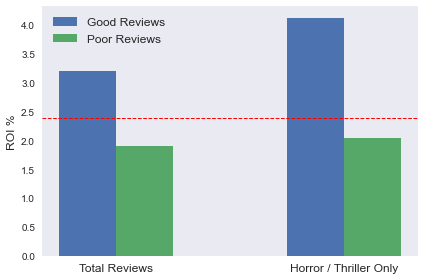

In [15]:
# Calculate combined reviews

fig, ax = plt.subplots(figsize=(6,4))

labels = ['Total Reviews', 'Horror / Thriller Only']
x = np.arange(len(labels))
width = 0.25

bars1 = total_review_tier.iloc[0,:]
bars2 = total_review_tier.iloc[1,:]

ax.bar(x - width/2, bars1, width, label='Good Reviews')
ax.bar(x + width/2, bars2, width, label='Poor Reviews')

ax.set_ylabel('ROI %', fontsize=12)
# ax.set_title('ROI by Review Category', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=12)
ax.grid(False)

plt.axhline(y=wavg,linewidth=1, color='red', linestyle='--')

plt.savefig('./images/Review_vs_ROI.png')

plt.tight_layout();

In [26]:
pickup_total = (total_review_tier.iloc[0,0] - total_review_tier.iloc[1,0]) / total_review_tier.iloc[1,0]
pickup_horror = (total_review_tier.iloc[0,1] - total_review_tier.iloc[1,1]) / total_review_tier.iloc[1,1]

print(pickup_total, pickup_horror)

0.6835709756339264 1.013906874358294


## ROI vs. Number of Twitter Reviews

Summary: the hypothesis is that number of reviews on Twitter, as a proxy for total social media engagement, would drive higher movie ROI
Analysis: The original dataset was grouped by year and vote count categoricals. I.e., before 2017 vs. after 2017 and high number of reviews vs. low number of reviews. The average ROI for these populations was recalculated.
Result: while there was a decent result for the overall population, what really stood out is that post 2017, twitter engagement really seems to matter - driving a 100%+ increase in ROI vs. movies that did not have high engagement.

In [16]:
twitter_review_count = imdb_total_f.groupby(['year_count', 'count_tier_twitter']).sum()

twitter_review_count['ROI_new'] = ((twitter_review_count['worldwide_gross_inf'] - twitter_review_count['production_budget_inf']) 
                                / twitter_review_count['production_budget_inf'])

twitter_review_count = twitter_review_count['ROI_new']

In [22]:
pickup_17_after = (twitter_review_count.iloc[0] - twitter_review_count.iloc[1]) / twitter_review_count.iloc[1]
pickup_17_before = (twitter_review_count.iloc[2] - twitter_review_count.iloc[3]) / twitter_review_count.iloc[3]

print(pickup_17_after, pickup_17_before)

1.150295946707588 0.5591560448839704


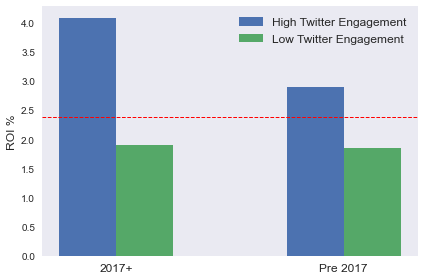

In [17]:
# Calculate combined review count tiers

fig, ax2 = plt.subplots(figsize=(6,4))

labels = ['2017+', 'Pre 2017']
x = np.arange(len(labels))
width = 0.25

bars1 = [twitter_review_count.iloc[0], twitter_review_count.iloc[2]]
bars2 = [twitter_review_count.iloc[1], twitter_review_count.iloc[3]]

ax2.bar(x - width/2, bars1, width, label='High Twitter Engagement')
ax2.bar(x + width/2, bars2, width, label='Low Twitter Engagement')

ax2.set_ylabel('ROI %', fontsize=12)
# ax2.set_title('ROI by Review Category', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(False)

plt.axhline(y=wavg,linewidth=1, color='red', linestyle='--')

plt.savefig('./images/twitter_engagement.png')

plt.tight_layout();

## Not in use

NameError: name 'review_tiers_combined' is not defined

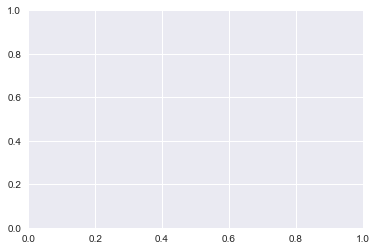

In [18]:
# Calculate combined reviews

fig, ax = plt.subplots(figsize=(6,4))

labels = ['IMDB Reviews', 'Twitter Reviews']
x = np.arange(len(labels))
width = 0.25

bars1 = review_tiers_combined.iloc[0,:]
bars2 = review_tiers_combined.iloc[1,:]

ax.bar(x - width/2, bars1, width, label='Good Reviews')
ax.bar(x + width/2, bars2, width, label='Poor Reviews')

ax.set_ylabel('ROI %')
ax.set_title('ROI by Review Category')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(False)

plt.tight_layout();

plt.savefig('./images/twitter_IMDB_reviews.png')

In [ ]:
# Does total review count matter by era (pre 2017 vs. post 2017)

year_group = imdb_total_f.groupby(['year_count', 'count_tier_twitter']).ROI_percent.mean()

In [ ]:
type(year_group)

In [ ]:
# Calculate combined reviews

fig, ax3 = plt.subplots(figsize=(6,4))

labels = ['2017+', 'Pre-2017']
x = np.arange(len(labels))
width = 0.25

bars1 = [year_group.iloc[0], year_group.iloc[2]]
bars2 = [year_group.iloc[1], year_group.iloc[3]]

ax3.bar(x - width/2, bars1, width, label='High Review Count')
ax3.bar(x + width/2, bars2, width, label='Low Review Count')

ax3.set_ylabel('ROI %')
ax3.set_title('ROI by Twitter Review Count')
ax3.set_xticks(x)
ax3.set_xticklabels(labels)
ax3.legend()
ax3.grid(False)

plt.tight_layout();
plt.savefig('./images/twitter_review_count.png')

In [ ]:
year_group

In [ ]:
# Use this if you want to revert back to the old version

# Group by review tier (good / bad) and then aggregate ROI percent

ROI_review_twitter = pd.DataFrame(imdb_total_f.groupby('review_tier_twitter').ROI_percent.mean())
ROI_review_IMDB = pd.DataFrame(imdb_total_f.groupby('review_tier_IMDB').ROI_percent.mean())

review_tiers_combined = ROI_review_IMDB.merge(ROI_review_twitter, how='left', left_index=True, right_index=True,
                     suffixes=('_IMDB', '_twitter'))

In [ ]:
# Quick summary stats for the movies

imdb_avg_review = w_avg(imdb_total_f, 'averagerating', 'numvotes')
imdb_median_review = imdb_total_f['averagerating'].median()

twitter_avg_review = w_avg(imdb_total_f, 'twitter_avg_rating', 'twitter_rating_count')
twitter_median_review = imdb_total_f['twitter_avg_rating'].median()

In [ ]:
# Filter out only horror and thriller movies

imdb_total_f['horror_thriller'] = imdb_total_f['genres'].apply(is_horror_thriller)
imdb_horror = imdb_total_f[imdb_total_f['horror_thriller'] == True]

In [ ]:
ROI_rev_count_horror = imdb_horror.groupby('count_tier_twitter').ROI_percent.mean()

In [ ]:
# Plot horror movies, high vs. low engagement

fig, ax8 = plt.subplots()

x = ROI_rev_count_horror.index
y = ROI_rev_count_horror.values
ax8.bar(x, y)

ax8.set_title('ROI by Total Review Tier')
ax8.set_xlabel('Review Count Tier')
ax8.set_ylabel('ROI %');

In [ ]:
# Does high vs. low vote count imply a different ROI %

ROI_rev_count_twitter = imdb_total_f.groupby('count_tier_twitter').ROI_percent.mean()

In [ ]:
fig, ax2 = plt.subplots()

x = ROI_rev_count_twitter.index
y = ROI_rev_count_twitter.values
ax2.bar(x, y)

ax2.set_title('ROI by Total Review Tier')
ax2.set_xlabel('Review Count Tier')
ax2.set_ylabel('ROI %');

In [ ]:
# Test scatter of horror / thriller twitter review count vs. ROI

fig, ax7 = plt.subplots()

x = imdb_horror['twitter_rating_count']
y = imdb_horror['ROI_percent']

ax7.scatter(x, y)

ax7.set_ylim([-100, 1000])

plt.tight_layout();

In [ ]:
# Filter for high budget movies

test = imdb_horror[imdb_horror['production_budget_inf'] >= 10000000]

In [ ]:
x = test['twitter_rating_count']
y = test['ROI_percent']

In [ ]:
high_budget = imdb_total_f[imdb_total_f['production_budget_inf'] >= 100000000]
low_budget = imdb_total_f[imdb_total_f['production_budget_inf'] < 10000000] #& (imdb_total_f['ROI_percent'] < 800)]

In [ ]:
corr1 = np.corrcoef(high_budget['twitter_rating_count'], high_budget['ROI_percent'])
corr2 = np.corrcoef(low_budget['twitter_rating_count'], low_budget['ROI_percent'])

In [ ]:
print(corr1[1], corr2[1])

In [ ]:
ax = sns.regplot(x=high_budget['twitter_rating_count'],y=high_budget['ROI_percent'], fit_reg=True)

ax.set(xlabel='Rating Count', ylabel='ROI %');

In [ ]:
ax = sns.regplot(x=low_budget['twitter_rating_count'],y=low_budget['ROI_percent'], fit_reg=True)

# plt.ylim(-100,800)

ax.set(xlabel='Rating Count', ylabel='ROI %');
# ax.set_ylim(-100,800)

In [ ]:
# Is there a relationship between number of reviews and ROI %

fig, ax6 = plt.subplots(ncols=2)

y = imdb_total_f['ROI_percent']

ax6[0].scatter(imdb_total_f['numvotes'], y)
ax6[1].scatter(imdb_total_f['twitter_rating_count'], y)

ax6[0].set_ylim([-100, 1000])
ax6[1].set_ylim([-100, 1000])

plt.tight_layout()

In [ ]:
# Review count summary stats

max_reviews = twitter_prof_f['rating_count'].max()
min_reviews = twitter_prof_f['rating_count'].min()
avg_num_reviews = twitter_prof_f['rating_count'].min()

In [ ]:
# Review summary stats

avg_review = w_avg(twitter_prof_f, 'avg_rating', 'rating_count')
median_review = twitter_prof_f['avg_rating'].median()

In [ ]:
# ax = sns.regplot(x=twitter_prof_f['avg_rating'],y=twitter_prof_f['ROI_percent'], fit_reg=True)

# ax.set(xlabel='Avg Rating', ylabel='ROI %');

In [ ]:
# Scatter plot of IMDB vs. Twitter reviews
# Commentary: twitter reviews and IMDB reviews appear to be very closely correlated.

fig, ax1 = plt.subplots()

ax1.scatter(imdb_total_f['twitter_avg_rating'], imdb_total_f['averagerating'], alpha = 0.5)
ax1.set_xlabel('Twitter Avg Rating')
ax1.set_ylabel('IMDB Avg Rating')
ax1.set_title('Twitter vs. IMDB Ratings');

In [ ]:
# Relationship between reviews and movie success: scatter plot
fig, (ax2, ax3) = plt.subplots(ncols=2, figsize=(10,4))

x1 = imdb_total_f['twitter_avg_rating']
x2 = imdb_total_f['averagerating']
y = imdb_total_f['ROI_percent']

ax2.scatter(x1, y, alpha=0.5)
ax3.scatter(x2, y, alpha=0.5)

ax2.set_title('Twitter ratings vs. ROI')
ax2.set_xlabel('Twitter Avg Rating')
ax2.set_ylabel('ROI %')
ax2.set_ylim([-100, 1000])

ax3.set_title('IMDB ratings vs. ROI')
ax3.set_xlabel('IMDB Avg Rating')
ax3.set_ylabel('ROI %')
ax3.set_ylim([-100, 1000])

plt.tight_layout();

In [ ]:
# Relationship between reviews and movie success by budget tier: scatter plot

fig, ax4 = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

custom_ylim = (-100, 1000)
custom_xlim = (0, 10)

# Setting the values for all axes.
plt.setp(ax4, ylim=custom_ylim)

xHighReview1 = imdb_total_f[imdb_total_f['review_tier_IMDB'] == 'High Review'].loc[:,'averagerating']
xMedReview1 = imdb_total_f[imdb_total_f['review_tier_IMDB'] == 'Medium Review'].loc[:,'averagerating']
xLowReview1 = imdb_total_f[imdb_total_f['review_tier_IMDB'] == 'Low Review'].loc[:,'averagerating']

xHighReview2 = imdb_total_f[imdb_total_f['review_tier_twitter'] == 'High Review'].loc[:,'twitter_avg_rating']
xMedReview2 = imdb_total_f[imdb_total_f['review_tier_twitter'] == 'Medium Review'].loc[:,'twitter_avg_rating']
xLowReview2 = imdb_total_f[imdb_total_f['review_tier_twitter'] == 'Low Review'].loc[:,'twitter_avg_rating']

yHigh1 = imdb_total_f[imdb_total_f['review_tier_IMDB'] == 'High Review'].loc[:,'ROI_percent']
yMed1 = imdb_total_f[imdb_total_f['review_tier_IMDB'] == 'Medium Review'].loc[:,'ROI_percent']
yLow1 = imdb_total_f[imdb_total_f['review_tier_IMDB'] == 'Low Review'].loc[:,'ROI_percent']

yHigh2 = imdb_total_f[imdb_total_f['review_tier_twitter'] == 'High Review'].loc[:,'ROI_percent']
yMed2 = imdb_total_f[imdb_total_f['review_tier_twitter'] == 'Medium Review'].loc[:,'ROI_percent']
yLow2 = imdb_total_f[imdb_total_f['review_tier_twitter'] == 'Low Review'].loc[:,'ROI_percent']

ax4[0,0].scatter(xHighReview1,yHigh1,alpha=0.5)
ax4[0,1].scatter(xMedReview1,yMed1,alpha=0.5)
ax4[0,2].scatter(xLowReview1,yLow1,alpha=0.5)

ax4[1,0].scatter(xHighReview2,yHigh2,alpha=0.5)
ax4[1,1].scatter(xMedReview2,yMed2,alpha=0.5)
ax4[1,2].scatter(xLowReview2,yLow2,alpha=0.5)

plt.tight_layout();

In [ ]:
# Explode out genre so you can explore Horror, specifically
# imdb_total_f.dropna(subset=['genres'], inplace=True)

# imdb_total_f.loc[:,'genres'] = imdb_total_f.loc[:,'genres'].apply(literal_eval)
# imdb_explode = imdb_total_f.explode('genres')

# # Filter only for horror movies
# imdb_horror = imdb_explode[(imdb_explode['genres'] == 'Horror') | (imdb_explode['genres'] == 'Thriller')]

In [ ]:
# Quick summary stats for the movies

imdb_avg_review = w_avg(imdb_total_f, 'averagerating', 'numvotes')
imdb_median_review = imdb_total_f['averagerating'].median()

twitter_avg_review = w_avg(imdb_total_f, 'twitter_avg_rating', 'twitter_rating_count')
twitter_median_review = imdb_total_f['twitter_avg_rating'].median()